In [63]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
cos = nn.CosineSimilarity(dim=0, eps=1e-9)
from torchvision import transforms
# from codes.models import ConvNet, resnet8, MLP
from utils import *
from torch.utils.data import DataLoader
from models import *
import random
from collections import Counter
from collections import OrderedDict
import seaborn as sns
import copy
device = "cuda"

# adjustable parameters
alpha_d = 10
local_ep = 5
mali_local_ep = 15
points = 41
global attack 
attack = "backdoor" #"backdoor", "tlp"
model_name = "resnet8" # "resnet8", "ConvNet"
num_classes = 10
dataset ="fmnist"

In [64]:

def get_delta_cos(model1, model2, model0_sd):
    flat_model0 = flat_dict(model0_sd)
    flat_model1 = flat_dict(model1.state_dict())
    flat_model2 = flat_dict(model2.state_dict())
    
    delta = torch.abs(flat_model1 - flat_model2)
    org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))
    return delta, 1-org_cos.item()

def model_eval(model, test_loader, attack):
    acc = eval_op_ensemble([model], test_loader)
    if attack == "tlp":
        asr = eval_op_ensemble_tr_lf_attack([model], test_loader)
    elif attack == "backdoor":
        asr = eval_op_ensemble_attack([model], test_loader)
    return list(acc.values())[0], list(asr.values())[0]


def sample_and_replace(model1, model2, model3, k_percent):
    """
    Randomly selects k% of parameters within each layer from model2 and replaces them in model1.
    Returns a new model (model3) with mixed parameters and a dictionary of replaced indices.
    """
    model_1_sd = {key: value.clone() for key, value in model1.state_dict().items()}
    model3.load_state_dict(model_1_sd)  # Start with model1's parameters
    replaced_params = {}
    
    state_dict = model3.state_dict()
    for param_name in model1.state_dict().keys():
        param1 = model1.state_dict()[param_name].clone()
        param2 = model2.state_dict()[param_name].clone()
        num_elements = param1.numel()
        num_replace = int((k_percent / 100) * num_elements)
        
        if num_replace > 0:
            indices = random.sample(range(num_elements), num_replace)
            param1.view(-1)[indices] = param2.view(-1)[indices]
            param1_flat = param1.view(-1)
            param2_flat = param2.view(-1)
            param1_flat[indices] = param2_flat[indices]
            state_dict[param_name] = param1.view(param1.shape)
            replaced_params[param_name] = indices
    
    model3.load_state_dict(state_dict)
    return model3, replaced_params




def sampling_experiment(model1, model2, model3, model0_sd, main_dataloader, device, k_percent, p):
    """
    Runs p sampling experiments, evaluates model3 on both main and side tasks.
    """
    model_1_sd = {key: value.clone() for key, value in model1.state_dict().items()}
    
    results = {}
    replaced_params_list=[]
    for i in range(p):    
        model3.load_state_dict(model_1_sd)
        model3, replaced_params = sample_and_replace(model1, model2, model3, k_percent)
        acc_, asr_  = model_eval(model3, main_dataloader, attack)
        delta, cos_dist = get_delta_cos(model1, model3, model0_sd)
        results[i] = (acc_, asr_, cos_dist)
        replaced_params_list.append({asr_:  replaced_params})
    return results, replaced_params_list, model3


def replaced_params_count(replaced_params_list):
    """
    Counts occurrences of values per layer across multiple replaced_params dictionaries.

    :param replaced_params_list: List of replaced_params dictionaries.
    :return: Dictionary where keys are layer names and values are Counters of occurrences.
    """
    layer_counts = {}

    for replaced_params in replaced_params_list:
        for layer, values in replaced_params.items():
            if layer not in layer_counts:
                layer_counts[layer] = Counter()
            layer_counts[layer].update(values)

    return layer_counts


def convert_to_state_dict(layer_counts, state_dict):
    ind_w = OrderedDict()
    
    # Iterate over the outer dictionary (float keys)
    for weight, layers in layer_counts.items():
        for layer_name, indices in layers.items():
            print("layer_name", layer_name, indices)
            # If the layer is not in state_dict, initialize it with an empty list of zeros
            if layer_name not in ind_w:
                ind_w[layer_name] = {}
            
            for index in range(state_dict[layer_name].numel()):  
                if index in indices:
                    # Add the weight to the corresponding index in the layer
                    if index not in ind_w[layer_name]:
                        ind_w[layer_name][index] = 0
                    ind_w[layer_name][index] += weight
                else:
                    # other not selected indices
                    ind_w[layer_name][index] = 0
            
    
    # print("ind_w keys", ind_w.keys())
    # print("state_dict keys", state_dict.keys())
    
    for name, asr_dict in ind_w.items():
        asr_w = torch.tensor([value for key, value in sorted(asr_dict.items())])
        print(f"name:{name}, asr_w:{asr_w.numel()}, state_dict:{state_dict[name].numel()}")
        state_dict[name] = asr_w.view(state_dict[name].shape)
    
    return state_dict


def plot_layer_weights(layer_name, params, title, save_plot=False):
    """
    Plots the weights of a specific layer in a PyTorch model as a heatmap.
    
    Parameters:
        layer (torch.nn.Module): The PyTorch layer (e.g., torch.nn.Linear, torch.nn.Conv2d).
        layer_name (str): A text string to label the plot and use in the filename.
        save_plot (bool): If True, saves the plot as a PNG file with the layer_name as part of the filename.
    """
    # Check if the layer has weights
    # if not hasattr(layer, 'weight'):
    #     raise ValueError(f"The provided layer does not have weights.")
    
    # Extract the weights
    params = params.reshape(params.size(0), -1)
    
    weights = params.cpu().numpy()
    
    # Plot the weights as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(weights, cmap="coolwarm", annot=False, cbar=True)
    plt.title(f'Weight Matrix of {layer_name} _ {title}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Input Index')
    
    if save_plot:
        # Save the plot with the layer_name as part of the filename
        filename = f"{layer_name}_{title}_weights_heatmap.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        print(f"Plot saved as {filename}")
    
    plt.show()

In [65]:


# Define transformation (convert images to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

# Load the training dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batch processing
client_loaders, test_loader, client_data_subsets =\
    data.get_loaders(train_data, test_data, n_clients=100,
                    alpha=alpha_d, batch_size=32, n_data=None, num_workers=4, seed=4)
    
model_fn = partial(models.get_model(model_name)[
                        0], num_classes=num_classes, dataset=dataset)

client_loader = client_loaders[0]

# created models
model1 = model_fn().to(device)
model2 = model_fn().to(device)
model3 = model_fn().to(device)

model0_sd = {k: v.clone().detach() for k, v in model1.state_dict().items()}

optimizer1 = optim.SGD(model1.parameters(), lr=0.001)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001)
optimizer3 = optim.SGD(model3.parameters(), lr=0.001)


Data split:
 - Client 0: [57 58 69 45 68 75 60 68 56 39]                         -> sum=595
 - Client 1: [61 71 49 54 64 68 58 52 59 64]                         -> sum=600
 - Client 2: [43 51 78 54 53 85 81 54 47 55]                         -> sum=601
 - Client 3: [76 54 72 52 69 71 33 41 55 76]                         -> sum=599
 - Client 4: [52 89 66 45 43 64 65 36 56 83]                         -> sum=599
 - Client 5: [ 33  28  59  88 114  69  34  62  43  71]               -> sum=601
 - Client 6: [61 72 27 86 50 74 72 66 40 52]                         -> sum=600
 - Client 7: [40 54 59 36 68 52 55 89 97 50]                         -> sum=600
 - Client 8: [72 53 25 96 71 60 67 55 55 47]                         -> sum=601
 - Client 9: [52 69 51 45 79 60 50 78 47 69]                         -> sum=600
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
 - Client 91: [39 66 82 85 72 58 45 50 41 63]                         -> sum=601
 - Client 92: 

In [66]:
# model1 train benign
train_op(model1, client_loader, optimizer1, epochs=local_ep, print_train_loss=True)

model1_sd = {key: value.clone() for key, value in model1.state_dict().items()}

# model2 train from model1
model2.load_state_dict(model1_sd)
if attack == "tlp":
    train_op_tr_flip(model2, client_loader, optimizer2, epochs=mali_local_ep, class_num=10, print_train_loss=True)
elif attack == "backdoor":
    train_op_backdoor(model2, client_loader, optimizer2, epochs=local_ep)

acc1, asr1 = model_eval(model1, test_loader, attack)
acc2, asr2 = model_eval(model2, test_loader, attack)

# delta, org_cos
delta0, org_cos2 = get_delta_cos(model1, model2, model0_sd)
print(f"model1 acc:{acc1}, asr:{asr1}, cos dist:{0}")
print(f"model2 acc:{acc2}, asr:{asr2}, cos dist:{org_cos2}")

results = {}
# replacing each layer in the malicious model with the benigh model to identify BC layers
model2_sd = {key: value.clone() for key, value in model2.state_dict().items()}
for name, params in model2.state_dict().items():
    # model3.load_state_dict(model2_sd)
    # model3.state_dict()[name] = model1.state_dict()[name].clone()
    model3_sd = copy.deepcopy(model2_sd)
    model3_sd[name] = model1_sd[name].clone()
    model3.load_state_dict(model3_sd)
    
    acc1, asr1 = model_eval(model3, test_loader, attack)

    # delta, org_cos
    delta, cos_dist = get_delta_cos(model1, model3, model0_sd)
    print(name, acc1, asr1, cos_dist)
    results[name] = (acc1, asr1, cos_dist)
    


[2.33, 2.33, 2.32, 2.32, 2.32, 2.32, 2.31, 2.31, 2.31, 2.31, 2.31, 2.3, 2.3, 2.3, 2.3, 2.3, 2.29, 2.29, 2.29, 2.29, 2.29, 2.29, 2.29, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.27, 2.27, 2.27, 2.27, 2.27, 2.27, 2.27, 2.27, 2.27, 2.26, 2.26, 2.26, 2.26, 2.26, 2.26, 2.26, 2.26, 2.26, 2.25]
model1 acc:0.1592, asr:0.0, cos dist:0
model2 acc:0.1, asr:1.0, cos dist:0.9998312018433353
f.0.weight 0.1 1.0 0.9998310995288193
f.1.weight 0.1 1.0 0.9998312093957793
f.1.bias 0.1 1.0 0.9998312112875283
f.1.running_mean 0.1 1.0 0.9998312009847723
f.1.running_var 0.1 1.0 0.9998311934468802
f.1.num_batches_tracked 0.1 1.0 0.9998237187683117
f.3.0.conv1.weight 0.1 1.0 0.9998316560522653
f.3.0.bn1.weight 0.1 1.0 0.9998312034149421
f.3.0.bn1.bias 0.1 1.0 0.9998312019888544
f.3.0.bn1.running_mean 0.1 1.0 0.9998311984818429
f.3.0.bn1.running_var 0.1 1.0 0.999831196575542
f.3.0.bn1.num_batches_tracked 0.1 1.0 0.9998237187683117
f.3.0.conv2.weight 0.1 1.0 0.999831596374861
f.3.0.bn2.weight 0.1 1.0 0.999

In [67]:
results

{'f.0.weight': (0.1, 1.0, 0.9998310995288193),
 'f.1.weight': (0.1, 1.0, 0.9998312093957793),
 'f.1.bias': (0.1, 1.0, 0.9998312112875283),
 'f.1.running_mean': (0.1, 1.0, 0.9998312009847723),
 'f.1.running_var': (0.1, 1.0, 0.9998311934468802),
 'f.1.num_batches_tracked': (0.1, 1.0, 0.9998237187683117),
 'f.3.0.conv1.weight': (0.1, 1.0, 0.9998316560522653),
 'f.3.0.bn1.weight': (0.1, 1.0, 0.9998312034149421),
 'f.3.0.bn1.bias': (0.1, 1.0, 0.9998312019888544),
 'f.3.0.bn1.running_mean': (0.1, 1.0, 0.9998311984818429),
 'f.3.0.bn1.running_var': (0.1, 1.0, 0.999831196575542),
 'f.3.0.bn1.num_batches_tracked': (0.1, 1.0, 0.9998237187683117),
 'f.3.0.conv2.weight': (0.1, 1.0, 0.999831596374861),
 'f.3.0.bn2.weight': (0.1, 1.0, 0.9998312032112153),
 'f.3.0.bn2.bias': (0.1, 1.0, 0.9998312029783847),
 'f.3.0.bn2.running_mean': (0.1, 1.0, 0.9998311990784714),
 'f.3.0.bn2.running_var': (0.1, 1.0, 0.9998311996168923),
 'f.3.0.bn2.num_batches_tracked': (0.1, 1.0, 0.9998237187683117),
 'f.4.0.conv1.

In [68]:
selected_layer = "classification_layer.weight"

In [69]:
model3_sd = copy.deepcopy(model1_sd)
model3_sd[selected_layer] = model2_sd[selected_layer].clone()
model3.load_state_dict(model3_sd)

acc1, asr1 = model_eval(model3, test_loader, attack)

# delta, org_cos
delta, cos_dist = get_delta_cos(model1, model3, model0_sd)
print(f"for {dataset} data, in {model_name}, with {attack}, acc: {acc1}, asr: {asr1}, cos_dist: {cos_dist}")

for fmnist data, in resnet8, with backdoor, acc: 0.1, asr: 1.0, cos_dist: 0.5051039755344391


In [82]:
def plot_layer_weights(layer_w, layer_name, save_plot=False):
    """
    Plots the weights of a specific layer in a PyTorch model as a heatmap.
    
    Parameters:
        layer (torch.nn.Module): The PyTorch layer (e.g., torch.nn.Linear, torch.nn.Conv2d).
        layer_name (str): A text string to label the plot and use in the filename.
        save_plot (bool): If True, saves the plot as a PNG file with the layer_name as part of the filename.
    """
    
    # Extract the weights
    weights = layer_w.cpu().numpy()
    
    # Plot the weights as a heatmap
    plt.figure(figsize=(20, 3))
    sns.heatmap(weights, cmap="coolwarm", annot=False, cbar=True)
    plt.title(f'Weight Matrix of {layer_name}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Input Index')
    
    if save_plot:
        # Save the plot with the layer_name as part of the filename
        filename = f"{layer_name}_weights_heatmap.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        print(f"Plot saved as {filename}")
    
    plt.show()

In [83]:
model1.state_dict()[selected_layer].size()

torch.Size([10, 512])

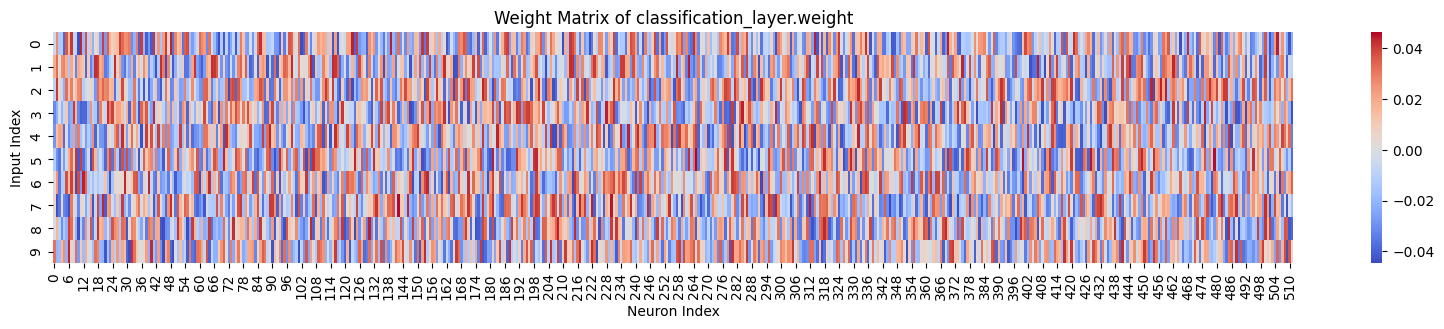

In [84]:
plot_layer_weights(model1.state_dict()[selected_layer], selected_layer, save_plot=False)

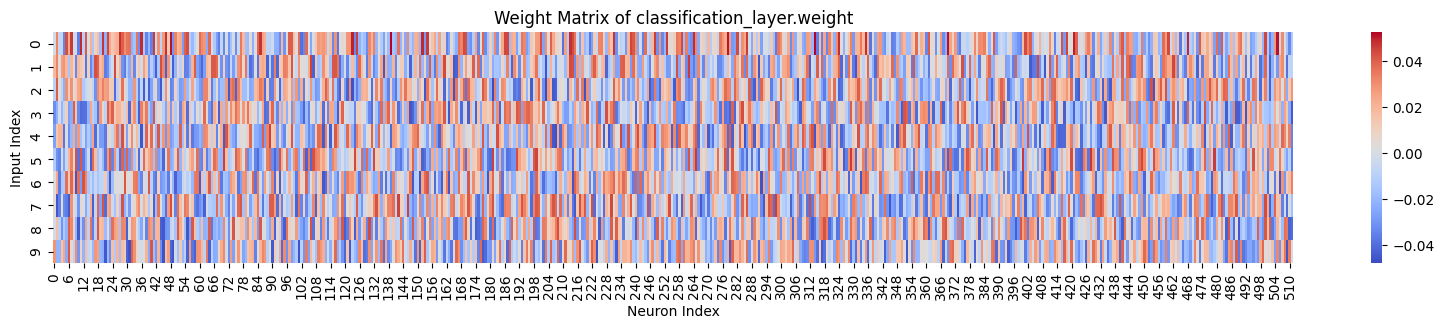

In [85]:
plot_layer_weights(model2.state_dict()[selected_layer], selected_layer, save_plot=False)

In [87]:
m1_cw = model1.state_dict()[selected_layer]
m2_cw = model2.state_dict()[selected_layer]

In [88]:
m1_cw

tensor([[-0.0050,  0.0267, -0.0137,  ..., -0.0242, -0.0425, -0.0213],
        [ 0.0189,  0.0324,  0.0016,  ..., -0.0394, -0.0050, -0.0077],
        [-0.0093,  0.0408,  0.0069,  ..., -0.0200,  0.0147,  0.0319],
        ...,
        [ 0.0052, -0.0434, -0.0351,  ..., -0.0425, -0.0002, -0.0178],
        [-0.0005,  0.0172, -0.0087,  ...,  0.0358, -0.0420, -0.0388],
        [ 0.0315, -0.0194, -0.0180,  ..., -0.0433,  0.0372,  0.0030]],
       device='cuda:0')

In [89]:
m2_cw

tensor([[-0.0003,  0.0325, -0.0058,  ..., -0.0163, -0.0335, -0.0118],
        [ 0.0187,  0.0323,  0.0022,  ..., -0.0389, -0.0075, -0.0081],
        [-0.0092,  0.0404,  0.0035,  ..., -0.0237,  0.0131,  0.0290],
        ...,
        [ 0.0041, -0.0451, -0.0351,  ..., -0.0398,  0.0005, -0.0170],
        [-0.0003,  0.0170, -0.0096,  ...,  0.0349, -0.0424, -0.0399],
        [ 0.0291, -0.0214, -0.0207,  ..., -0.0455,  0.0342, -0.0002]],
       device='cuda:0')

In [104]:
def compute_similarity_and_distance(a, b):
    """
    Compute cosine similarity and L2 distance between two tensors.

    Args:
        a (torch.Tensor): First tensor.
        b (torch.Tensor): Second tensor.

    Returns:
        cos_sim (float): Cosine similarity between a and b.
        l2_dist (float): L2 distance (Euclidean distance) between a and b.
    """
    # Ensure the tensors are of the same size
    assert a.size() == b.size(), "Tensors must be of the same size"

    # Compute cosine similarity
    cos_sim = torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0))
    print(cos_sim)

    # Compute L2 distance (Euclidean distance)
    l2_dist = torch.norm(a - b, p=2)

    return cos_sim.item(), l2_dist.item()

In [105]:
m1_cw.flatten().size()

torch.Size([5120])

In [106]:
compute_similarity_and_distance(m1_cw, m2_cw)

tensor([[0.9954, 0.9981, 0.9907, 0.9940, 0.9979, 0.9957, 0.9962, 0.9979, 0.9934,
         0.9961, 0.9969, 0.9975, 0.9933, 0.9985, 0.9363, 0.9942, 0.9954, 0.9904,
         0.9962, 0.9949, 0.9964, 0.9976, 0.9938, 0.9969, 0.9937, 0.9943, 0.9880,
         0.9949, 0.9963, 0.9980, 0.9946, 0.9960, 0.9928, 0.9980, 0.9900, 0.9947,
         0.9950, 0.9943, 0.9969, 0.9947, 0.9967, 0.9987, 0.9928, 0.9971, 0.9966,
         0.9986, 0.9968, 0.9934, 0.9969, 0.9965, 0.9969, 0.9950, 0.9958, 0.9900,
         0.9975, 0.9984, 0.9899, 0.9956, 0.9942, 0.9956, 0.9986, 0.9982, 0.9976,
         0.9974, 0.9961, 0.9945, 0.9967, 0.9965, 0.9929, 0.9959, 0.9938, 0.9905,
         0.9980, 0.9942, 0.9936, 0.9920, 0.9952, 0.9966, 0.9932, 0.9935, 0.9930,
         0.9969, 0.9960, 0.9948, 0.9979, 0.9973, 0.9929, 0.9926, 0.9958, 0.9988,
         0.9988, 0.9974, 0.9973, 0.9956, 0.9935, 0.9988, 0.9926, 0.9967, 0.9972,
         0.9909, 0.9984, 0.9974, 0.9976, 0.9976, 0.9953, 0.9930, 0.9965, 0.9990,
         0.9963, 0.9959, 0.9

RuntimeError: a Tensor with 512 elements cannot be converted to Scalar